In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from faster_rcnn.utils.datasets.voc.voc import VOCDetection
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from faster_rcnn.utils.datasets.data_generator import CocoGenerator
from faster_rcnn.utils.datasets.data_generator import Enqueuer
from torch.optim import SGD, RMSprop, Adam

from faster_rcnn.faster_rcnn import FastRCNN, RPN
from pycrayon import CrayonClient
import torch
from torch.optim.lr_scheduler import StepLR
from datetime import datetime
from faster_rcnn.utils.datasets.adapter import convert_data
from faster_rcnn.utils.evaluate.metter import AverageMeter
from faster_rcnn.utils.display.images import imshow, result_show

In [3]:
root = '/data/data'
ds = VOCDetection(root, 'train')
val_ds = VOCDetection(root, 'val')
print(len(ds), len(val_ds))

(245, 35)


In [4]:
batch_size = 3

In [5]:
data_gen = CocoGenerator(data=ds, batch_size=batch_size, shuffle=True)
queue = Enqueuer(generator=data_gen, use_multiprocessing=False)
queue.start(max_queue_size=20, workers=4)
train_data_generator = queue.get()

In [6]:
val_data_gen = CocoGenerator(data=ds, batch_size=batch_size, shuffle=True, seed=2)
val_queue = Enqueuer(generator=data_gen, use_multiprocessing=False)
val_queue.start(max_queue_size=20, workers=4)
val_data_generator = val_queue.get()

In [7]:
categories = ds.classes
print(categories)

['__background__', u'276', u'723']


In [8]:
net = FastRCNN(categories, debug=False)
net.cuda()
net.train()

/opt/conda/envs/pytorch/lib/python2.7/site-packages/torch/nn/parallel/data_parallel.py:24: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 0 which
    has less than 75% of the memory or cores of GPU 1. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


FastRCNN(
  (rpn): RPN(
    (features): DataParallel(
      (module): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): ReLU(inplace)
        (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): ReLU(inplace)
        (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): ReLU(inplace)
        (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (13): ReLU(inplace)
        (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (15): 

In [9]:
params = filter(lambda x: x.requires_grad, net.parameters())
optimizer = SGD(params, lr=1e-4, momentum=0.9, weight_decay=0.0005)
exp_lr_scheduler = StepLR(optimizer, step_size=100, gamma=0.8)

In [10]:
def evaluate(data_gen ,model, steps_per_epoch, epochs=1):
    exp_name = datetime.now().strftime('vgg16_%m-%d_%H-%M-%s')
    cc = CrayonClient(hostname="crayon", port=8889)
    exp = cc.create_experiment(exp_name)
    
    model.eval()
    val_loss = AverageMeter()
    val_cross_entropy = AverageMeter()
    val_loss_box = AverageMeter()
    val_rpn_loss = AverageMeter()
    
    for epoch in range(epochs):
        for step in range(1, steps_per_epoch +1):
            blobs = data_gen.next()
            batch_tensor, im_info, batch_boxes, batch_boxes_index = convert_data(blobs)
            cls_prob, bbox_pred, rois = model(batch_tensor, im_info, batch_boxes, batch_boxes_index)

            loss = model.loss
            
            val_loss_box.update(model.loss_box.item())
            val_cross_entropy.update(model.cross_entropy.item())
            val_loss.update(loss.item())
            val_rpn_loss.update(model.rpn.loss.item())
    
    log_text = 'val_loss: %.4f' % (val_loss.avg)
    print(log_text)
    return val_loss ,val_cross_entropy, val_loss_box, val_rpn_loss


In [11]:
def train(train_data_gen, val_data_gen, optimizer, lr_scheduler ,model, epochs, steps_per_epoch, val_step_per_epoch):
    
    exp_name = datetime.now().strftime('vgg16_%m-%d_%H-%M-%s')
    cc = CrayonClient(hostname="crayon", port=8889)
    exp = cc.create_experiment(exp_name)
    
    
    train_loss = AverageMeter()
    cross_entropy = AverageMeter()
    loss_box = AverageMeter()
    rpn_loss = AverageMeter()
    current_step = 0
    
    for epoch in range(epochs):
        model.train()
        for step in range(1, steps_per_epoch +1):
            lr_scheduler.step()        
            blobs = data_gen.next()
            batch_tensor, im_info, batch_boxes, batch_boxes_index = convert_data(blobs)

            cls_prob, bbox_pred, rois = model(batch_tensor, im_info, batch_boxes, batch_boxes_index)
            cls_data = cls_prob.data.cpu().numpy()
            max_class_idx = np.argmax(cls_data, axis=1)
            loss = model.loss
            cross_entropy.update(model.cross_entropy.item())
            loss_box.update(model.loss_box.item())
            train_loss.update(loss.item())
            rpn_loss.update(model.rpn.loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            current_step = epoch * steps_per_epoch + step
            if step % 10 == 0:
                log_text = 'epoch: %d : step %d,  loss: %.4f' % (
                    epoch + 1, step , train_loss.avg)
                print(log_text)

                re_cnt = True
            if step % 10 == 0:
                exp.add_scalar_value('train_loss', train_loss.avg, step=current_step)
                exp.add_scalar_value('rpn_loss', rpn_loss.avg, step=current_step)
                exp.add_scalar_value('cross_entropy', cross_entropy.avg, step=current_step)
                exp.add_scalar_value('loss_box', loss_box.avg, step=current_step)


                
        torch.save(model.state_dict(), './checkpoints/faster_model_at_epoch_%s.pkl' % epoch + 1) 
        val_loss ,val_cross_entropy, val_loss_box, val_rpn_loss = evaluate(val_data_gen, model, val_step_per_epoch)
        exp.add_scalar_value('val_loss', val_loss.avg, step=current_step)
        exp.add_scalar_value('val_rpn_loss', val_rpn_loss.avg, step=current_step)
        exp.add_scalar_value('val_cross_entropy', val_cross_entropy.avg, step=current_step)
        exp.add_scalar_value('val_loss_box', val_loss_box.avg, step=current_step)

In [12]:
train(train_data_generator, val_data_generator ,optimizer=optimizer,lr_scheduler=exp_lr_scheduler, model=net, epochs=10, steps_per_epoch=100, val_step_per_epoch=15)

faster_rcnn/faster_rcnn.py:169: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  cls_prob = F.softmax(cls_score)


epoch: 1 : step 10,  loss: 5.0192
epoch: 1 : step 20,  loss: 3.9577
epoch: 1 : step 30,  loss: 3.4115
epoch: 1 : step 40,  loss: 3.1217
epoch: 1 : step 50,  loss: 2.9148
epoch: 1 : step 60,  loss: 2.7841
epoch: 1 : step 70,  loss: 2.6765
epoch: 1 : step 80,  loss: 2.5952
epoch: 1 : step 90,  loss: 2.5265
epoch: 1 : step 100,  loss: 2.4733
val_loss: 2.0767
epoch: 2 : step 10,  loss: 2.4353
epoch: 2 : step 20,  loss: 2.3974
epoch: 2 : step 30,  loss: 2.3686
epoch: 2 : step 40,  loss: 2.3471
epoch: 2 : step 50,  loss: 2.3279
epoch: 2 : step 60,  loss: 2.3041
epoch: 2 : step 70,  loss: 2.2816
epoch: 2 : step 80,  loss: 2.2663
epoch: 2 : step 90,  loss: 2.2476
epoch: 2 : step 100,  loss: 2.2308
val_loss: 1.8522
epoch: 3 : step 10,  loss: 2.2142
epoch: 3 : step 20,  loss: 2.2033
epoch: 3 : step 30,  loss: 2.1916
epoch: 3 : step 40,  loss: 2.1806
epoch: 3 : step 50,  loss: 2.1749
epoch: 3 : step 60,  loss: 2.1665
epoch: 3 : step 70,  loss: 2.1589
epoch: 3 : step 80,  loss: 2.1485
epoch: 3 : s

In [ ]:
net.load_state_dict(torch.load('faster_model_at_step_500.pkl'))

(u'723', (263.5376754508421, 92.40896725095155), (526.0974038374402, 566.0853666719115))


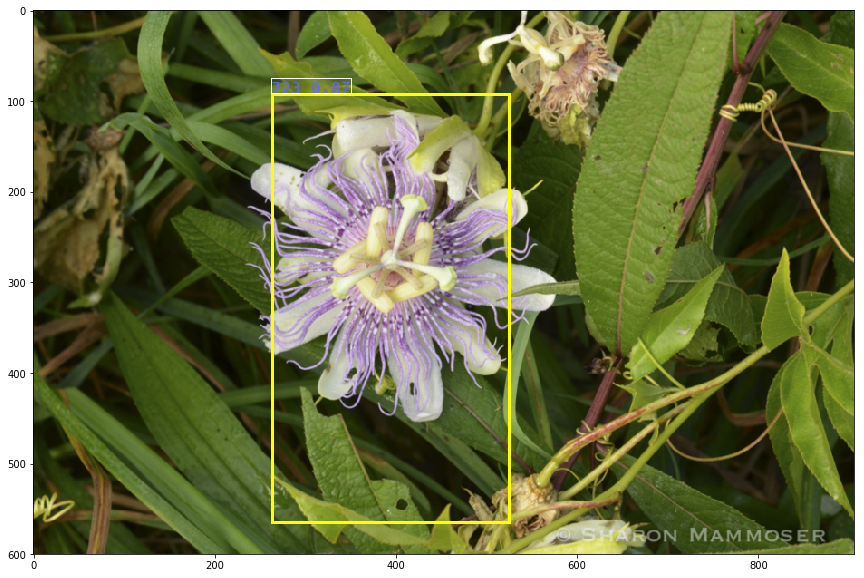

In [20]:
pred_boxes, scores, classes, rois, blob = net.detect('./test_im/test5.jpg', thr=0.8)
result_show(blob[0], pred_boxes,classes, scores)